# Homework 9: CI/CD Pipeline with Auto-Tests and Hallucination Detection

## Objectives
1. Build a simple RAG (Retrieval-Augmented Generation) QA system using Ollama + ChromaDB
2. Prepare 15 golden examples with ground-truth answers
3. Evaluate with Ragas metrics: **Faithfulness**, **Answer Relevancy**, **Context Recall**
4. Wrap evaluations in pytest tests with quality thresholds (>= 0.7)
5. Configure GitHub Actions CI/CD pipeline with quality gates

### Metrics Used
| Metric | Description | Threshold |
|--------|-------------|----------|
| **Faithfulness** | Checks if the answer is grounded in retrieved contexts (hallucination detection) | >= 0.7 |
| **Answer Relevancy** | Checks if the answer is relevant to the question | >= 0.7 |
| **Context Recall** | Checks if retrieved contexts contain the needed information vs ground truth | >= 0.7 |

### Architecture
```
Knowledge Base (10 docs) -> ChromaDB (embeddings) -> Retriever (top-3)
     |                                                     |
     v                                                     v
Golden Examples (15 Q&A) -----> Ollama LLM -----> Generated Answers
     |                                                     |
     v                                                     v
Ground Truth  ---------> Ragas Evaluation ---------> Metrics & Report
                              |                            |
                              v                            v
                         pytest tests  -------->  CI/CD Quality Gates
```

## 1. Setup and Dependencies

In [21]:
%pip install -q ragas>=0.2.0 datasets>=2.14.0 transformers>=4.30.0 \
    sentence-transformers>=2.2.0 langchain>=0.2.0 langchain-ollama>=0.1.0 \
    langchain-community>=0.2.0 chromadb>=0.4.0 pytest>=7.4.0 \
    pandas>=2.0.0 numpy>=1.24.0 matplotlib>=3.7.0 seaborn>=0.12.0 tqdm>=4.65.0

Note: you may need to restart the kernel to use updated packages.


## 2. Imports and Configuration

In [22]:
import json
import os
import time
import warnings
from dataclasses import dataclass, field
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings("ignore")

# CI/CD environment detection
IS_CI = os.environ.get("CI", "false").lower() == "true"
if IS_CI:
    print("[CI] Running in CI/CD environment - will use reduced timeouts and verbose logging")
else:
    print("[LOCAL] Running locally")


Core imports loaded successfully.


In [23]:
import requests

@dataclass
class Config:
    """Configuration for the RAG pipeline and evaluation."""
    # Ollama settings
    ollama_base_url: str = "http://localhost:11434"
    ollama_model: str = ""  # Auto-detected below
    
    # Embedding settings
    embedding_model: str = "all-MiniLM-L6-v2"
    
    # RAG settings
    collection_name: str = "ml_knowledge_base"
    top_k: int = 3
    
    # Evaluation thresholds
    faithfulness_threshold: float = 0.7
    answer_relevancy_threshold: float = 0.7
    context_recall_threshold: float = 0.7
    
    # Paths
    goldens_path: str = "tests/goldens.json"
    results_json_path: str = "ragas_results.json"
    results_csv_path: str = "evaluation_metrics.csv"


config = Config()

# Auto-detect available Ollama models
PREFERRED_MODELS = ["qwen2.5:1.5b", "llama3.2:3b", "llama3.2:latest", "gemma2:2b", "mistral:latest"]

try:
    resp = requests.get(f"{config.ollama_base_url}/api/tags", timeout=5)
    available_models = [m["name"] for m in resp.json().get("models", [])]
    # Filter out embedding-only models
    chat_models = [m for m in available_models if "embed" not in m.lower()]
    print(f"Available Ollama chat models: {chat_models}")
    
    # Pick the first preferred model that's available
    for preferred in PREFERRED_MODELS:
        if preferred in chat_models:
            config.ollama_model = preferred
            break
    # Fallback to first available chat model
    if not config.ollama_model and chat_models:
        config.ollama_model = chat_models[0]
    
    if not config.ollama_model:
        print("WARNING: No chat models found in Ollama!")
    else:
        print(f"Selected model: {config.ollama_model}")
except Exception as e:
    print(f"WARNING: Cannot connect to Ollama at {config.ollama_base_url}: {e}")
    print("Will use extractive fallback for answer generation.")
    config.ollama_model = "qwen2.5:1.5b"  # default name even if unavailable

print(f"\nConfiguration:")
print(f"  Ollama model: {config.ollama_model}")
print(f"  Embedding model: {config.embedding_model}")
print(f"  Top-K retrieval: {config.top_k}")
print(f"  Thresholds: Faithfulness>={config.faithfulness_threshold}, "
      f"Relevancy>={config.answer_relevancy_threshold}, "
      f"Context Recall>={config.context_recall_threshold}")

Available Ollama chat models: ['qwen2.5:1.5b']
Selected model: qwen2.5:1.5b

Configuration:
  Ollama model: qwen2.5:1.5b
  Embedding model: all-MiniLM-L6-v2
  Top-K retrieval: 3
  Thresholds: Faithfulness>=0.7, Relevancy>=0.7, Context Recall>=0.7


## 3. Knowledge Base and Golden Examples

In [24]:
# Load golden examples from JSON
with open(config.goldens_path, "r") as f:
    goldens_data = json.load(f)

knowledge_base = goldens_data["knowledge_base"]
golden_examples = goldens_data["golden_examples"]

print(f"Loaded {len(knowledge_base)} knowledge base documents")
print(f"Loaded {len(golden_examples)} golden examples")
print(f"\nKnowledge base topics:")
for doc in knowledge_base:
    print(f"  - {doc['title']} ({len(doc['content'])} chars)")

print(f"\nSample golden example:")
print(f"  Q: {golden_examples[0]['question']}")
print(f"  A: {golden_examples[0]['ground_truth']}")

Loaded 10 knowledge base documents
Loaded 15 golden examples

Knowledge base topics:
  - Neural Networks (531 chars)
  - Gradient Descent (538 chars)
  - Overfitting and Regularization (594 chars)
  - Transfer Learning (570 chars)
  - Natural Language Processing (494 chars)
  - Convolutional Neural Networks (577 chars)
  - Recurrent Neural Networks (587 chars)
  - Transformer Architecture (637 chars)
  - Reinforcement Learning (584 chars)
  - Generative Adversarial Networks (563 chars)

Sample golden example:
  Q: What is a neural network and what are its main components?
  A: A neural network is a computational model inspired by biological neural networks. Its main components are interconnected nodes (neurons) organized in layers: an input layer, hidden layers, and an output layer, with weighted connections between them.


## 4. Build RAG System with ChromaDB

In [25]:
import chromadb
from chromadb.utils import embedding_functions


class SimpleRAG:
    """Simple RAG system using ChromaDB for retrieval and Ollama for generation."""
    
    def __init__(self, config: Config):
        self.config = config
        self.client = chromadb.Client()
        self.ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name=config.embedding_model
        )
        # Delete collection if it already exists (for re-runs)
        try:
            self.client.delete_collection(config.collection_name)
        except Exception:
            pass
        self.collection = self.client.create_collection(
            name=config.collection_name,
            embedding_function=self.ef
        )
        self.ollama_available = False
    
    def index_documents(self, documents: list[dict]):
        """Index knowledge base documents into ChromaDB."""
        self.collection.add(
            documents=[doc["content"] for doc in documents],
            ids=[doc["id"] for doc in documents],
            metadatas=[{"title": doc["title"]} for doc in documents]
        )
        print(f"Indexed {len(documents)} documents into ChromaDB")
    
    def retrieve(self, query: str, top_k: int = None) -> list[str]:
        """Retrieve top-k relevant documents for a query."""
        k = top_k or self.config.top_k
        results = self.collection.query(
            query_texts=[query],
            n_results=k
        )
        return results["documents"][0]
    
    def check_ollama(self) -> bool:
        """Check if Ollama is available and the configured model exists."""
        try:
            resp = requests.get(f"{self.config.ollama_base_url}/api/tags", timeout=5)
            if resp.status_code != 200:
                self.ollama_available = False
                return False
            models = [m["name"] for m in resp.json().get("models", [])]
            if self.config.ollama_model not in models:
                print(f"WARNING: Model '{self.config.ollama_model}' not found in Ollama.")
                print(f"Available models: {models}")
                # Try to pick an alternative
                chat_models = [m for m in models if "embed" not in m.lower()]
                if chat_models:
                    self.config.ollama_model = chat_models[0]
                    print(f"Switched to: {self.config.ollama_model}")
                else:
                    self.ollama_available = False
                    return False
            self.ollama_available = True
        except Exception:
            self.ollama_available = False
        return self.ollama_available
    
    def generate_answer(self, question: str, contexts: list[str]) -> str:
        """Generate an answer using Ollama LLM with retrieved contexts."""
        context_text = "\n\n".join(contexts)
        prompt = (
            f"Based on the following context, answer the question concisely and accurately. "
            f"Only use information from the provided context.\n\n"
            f"Context:\n{context_text}\n\n"
            f"Question: {question}\n\n"
            f"Answer:"
        )
        
        if self.ollama_available:
            from langchain_ollama import ChatOllama
            llm = ChatOllama(
                model=self.config.ollama_model,
                base_url=self.config.ollama_base_url,
                temperature=0.1
            )
            response = llm.invoke(prompt)
            return response.content
        else:
            return self._extract_answer_from_context(question, contexts)
    
    def _extract_answer_from_context(self, question: str, contexts: list[str]) -> str:
        """Simple extractive fallback when LLM is not available."""
        question_words = set(question.lower().split())
        best_sentences = []
        for ctx in contexts:
            for sentence in ctx.split('. '):
                sentence_words = set(sentence.lower().split())
                overlap = len(question_words & sentence_words)
                best_sentences.append((overlap, sentence.strip()))
        best_sentences.sort(key=lambda x: x[0], reverse=True)
        answer = '. '.join([s[1] for s in best_sentences[:3]])
        if not answer.endswith('.'):
            answer += '.'
        return answer


# Initialize RAG system
rag = SimpleRAG(config)
rag.index_documents(knowledge_base)

# Check Ollama availability (also verifies model exists)
ollama_available = rag.check_ollama()
print(f"\nOllama available: {ollama_available}")
if ollama_available:
    print(f"Using model: {config.ollama_model}")
else:
    print("WARNING: Ollama is not running. Using extractive fallback for answer generation.")
    print("For best results, start Ollama with: ollama serve")
    print(f"And pull a model: ollama pull qwen2.5:1.5b")

Indexed 10 documents into ChromaDB

Ollama available: True
Using model: qwen2.5:1.5b


In [26]:
# Test retrieval
test_query = "What is a neural network?"
retrieved = rag.retrieve(test_query, top_k=2)
print(f"Query: {test_query}")
print(f"\nRetrieved {len(retrieved)} documents:")
for i, doc in enumerate(retrieved):
    print(f"\n--- Document {i+1} ---")
    print(doc[:200] + "...")

Query: What is a neural network?

Retrieved 2 documents:

--- Document 1 ---
A neural network is a computational model inspired by the structure and function of biological neural networks in the human brain. It consists of interconnected nodes (neurons) organized in layers: an...

--- Document 2 ---
Gradient descent is an optimization algorithm used to minimize a loss function by iteratively adjusting model parameters in the direction of steepest descent. The learning rate controls the step size ...


## 5. Generate Answers for Golden Examples

In [27]:
# Generate answers using RAG pipeline
questions = []
answers = []
contexts = []
ground_truths = []

# In CI, optionally limit samples to speed things up
max_samples = len(golden_examples)
if IS_CI and os.environ.get("CI_MAX_SAMPLES"):
    max_samples = int(os.environ.get("CI_MAX_SAMPLES"))
    print(f"[CI] Limiting to {max_samples} samples (CI_MAX_SAMPLES={max_samples})")

samples_to_process = golden_examples[:max_samples]
print(f"Generating answers for {len(samples_to_process)} golden examples...\n")

for idx, example in enumerate(tqdm(samples_to_process, desc="Processing")):
    question = example["question"]
    ground_truth = example["ground_truth"]
    
    t0 = time.time()
    print(f"[{idx+1}/{len(samples_to_process)}] Q: {question[:80]}...")
    
    # Retrieve relevant contexts
    retrieved_contexts = rag.retrieve(question)
    t_retrieve = time.time() - t0
    print(f"  Retrieval: {t_retrieve:.1f}s ({len(retrieved_contexts)} docs)")
    
    # Generate answer
    t1 = time.time()
    answer = rag.generate_answer(question, retrieved_contexts)
    t_generate = time.time() - t1
    print(f"  Generation: {t_generate:.1f}s ({len(answer)} chars)")
    
    questions.append(question)
    answers.append(answer)
    contexts.append(retrieved_contexts)
    ground_truths.append(ground_truth)

print(f"\nGenerated {len(answers)} answers.")
print(f"\nExample:")
print(f"  Q: {questions[0]}")
print(f"  Generated A: {answers[0][:200]}...")
print(f"  Ground Truth: {ground_truths[0][:200]}")


Generating answers for golden examples...



Processing: 100%|██████████| 15/15 [00:48<00:00,  3.25s/it]


Generated 15 answers.

Example:
  Q: What is a neural network and what are its main components?
  Generated A: A neural network is a computational model inspired by the structure and function of biological neural networks in the human brain. It consists of interconnected nodes (neurons) organized in layers: an...
  Ground Truth: A neural network is a computational model inspired by biological neural networks. Its main components are interconnected nodes (neurons) organized in layers: an input layer, hidden layers, and an outp


## 6. Ragas Evaluation

We evaluate the RAG pipeline using three Ragas metrics:
- **Faithfulness**: Measures if the generated answer is factually consistent with the retrieved context
- **Answer Relevancy**: Measures if the answer addresses the question
- **Context Recall**: Measures if the retrieved contexts contain the information from the ground truth

In [28]:
from datasets import Dataset

# Prepare evaluation dataset
eval_data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}

eval_dataset = Dataset.from_dict(eval_data)
print(f"Evaluation dataset: {eval_dataset}")
print(f"\nColumns: {eval_dataset.column_names}")
print(f"Num samples: {len(eval_dataset)}")

Evaluation dataset: Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 15
})

Columns: ['question', 'answer', 'contexts', 'ground_truth']
Num samples: 15


In [29]:
# Configure Ragas with Ollama
ragas_llm = None
ragas_embeddings = None

try:
    if ollama_available:
        print("[RAGAS CONFIG] Configuring Ragas with Ollama backend...")
        from openai import OpenAI
        from ragas.llms import llm_factory
        from ragas.embeddings import LangchainEmbeddingsWrapper
        from langchain_ollama import OllamaEmbeddings

        # LLM via Ollama's OpenAI-compatible endpoint (required by ragas 0.4.x)
        openai_client = OpenAI(
            base_url=f"{config.ollama_base_url}/v1",
            api_key="ollama"
        )
        ragas_llm = llm_factory(config.ollama_model, client=openai_client)
        print(f"[RAGAS CONFIG] LLM configured: {config.ollama_model} via OpenAI-compat API")

        # Embeddings via LangchainEmbeddingsWrapper (needed for AnswerRelevancy)
        embed_model_name = None
        try:
            resp = requests.get(f"{config.ollama_base_url}/api/tags", timeout=5)
            all_models = [m["name"] for m in resp.json().get("models", [])]
            embed_candidates = [m for m in all_models if "embed" in m.lower()]
            if embed_candidates:
                embed_model_name = embed_candidates[0]
                print(f"[RAGAS CONFIG] Found Ollama embedding model: {embed_model_name}")
        except Exception:
            pass

        if embed_model_name:
            ragas_embeddings = LangchainEmbeddingsWrapper(
                OllamaEmbeddings(model=embed_model_name, base_url=config.ollama_base_url)
            )
            print(f"[RAGAS CONFIG] Embeddings configured: {embed_model_name}")
        else:
            print("[RAGAS CONFIG] WARNING: No Ollama embedding model found. AnswerRelevancy may not work.")
    else:
        print("[RAGAS CONFIG] Ollama not available. Will use manual metric computation.")
except Exception as e:
    print(f"[RAGAS CONFIG] Error configuring Ragas: {e}")
    print("[RAGAS CONFIG] Will attempt evaluation with available configuration.")


Ragas LLM configured: qwen2.5:1.5b via OpenAI-compat API
Found Ollama embedding model: nomic-embed-text:latest
Ragas embeddings configured: nomic-embed-text:latest


In [30]:
# Run Ragas evaluation (using old-style metrics compatible with evaluate())
import signal
import threading
from ragas import evaluate
from ragas.metrics._faithfulness import Faithfulness
from ragas.metrics._answer_relevance import AnswerRelevancy
from ragas.metrics._context_recall import ContextRecall

ragas_metrics = [Faithfulness(), AnswerRelevancy(), ContextRecall()]

# Timeout for Ragas evaluation: 8 min in CI, 20 min locally
RAGAS_TIMEOUT = 480 if IS_CI else 1200
ragas_succeeded = False
aggregate_metrics = {}
result_df = None

def run_ragas_evaluation():
    """Run Ragas evaluation in a separate thread for timeout control."""
    global ragas_succeeded, aggregate_metrics, result_df, _ragas_error
    _ragas_error = None
    try:
        print(f"[RAGAS] Starting evaluation with timeout={RAGAS_TIMEOUT}s...")
        print(f"[RAGAS] Dataset: {len(eval_dataset)} samples, 3 metrics")
        print(f"[RAGAS] Metrics: Faithfulness, AnswerRelevancy, ContextRecall")
        t0 = time.time()
        
        result = evaluate(
            eval_dataset,
            metrics=ragas_metrics,
            llm=ragas_llm,
            embeddings=ragas_embeddings,
        )
        
        elapsed = time.time() - t0
        print(f"[RAGAS] Evaluation completed in {elapsed:.1f}s")

        ragas_succeeded = True

        # Get per-sample results via to_pandas()
        try:
            result_df = result.to_pandas()
            print(f"[RAGAS] Per-sample results shape: {result_df.shape}")
        except Exception as e:
            print(f"[RAGAS] Could not get per-sample DataFrame: {e}")

        # Extract aggregate metrics from the result object
        metric_names = ["faithfulness", "answer_relevancy", "context_recall"]
        for metric_name in metric_names:
            try:
                val = float(result[metric_name])
                aggregate_metrics[metric_name] = val
            except Exception:
                if result_df is not None and metric_name in result_df.columns:
                    aggregate_metrics[metric_name] = float(result_df[metric_name].mean())

        print("[RAGAS] Evaluation Results:")
        for metric_name in metric_names:
            if metric_name in aggregate_metrics:
                print(f"  {metric_name:20s}: {aggregate_metrics[metric_name]:.4f}")
            else:
                print(f"  {metric_name:20s}: N/A")
    except Exception as e:
        _ragas_error = e
        print(f"[RAGAS] Evaluation error: {e}")

try:
    if ragas_llm is not None:
        # Run evaluation in a thread with timeout
        eval_thread = threading.Thread(target=run_ragas_evaluation, daemon=True)
        eval_thread.start()
        eval_thread.join(timeout=RAGAS_TIMEOUT)
        
        if eval_thread.is_alive():
            print(f"[RAGAS] TIMEOUT: Evaluation exceeded {RAGAS_TIMEOUT}s limit!")
            print("[RAGAS] Falling back to manual metric computation...")
            ragas_succeeded = False
        elif not ragas_succeeded:
            err_msg = getattr(_ragas_error, '__str__', lambda: 'Unknown error')() if '_ragas_error' in dir() and _ragas_error else 'Unknown error'
            print(f"[RAGAS] Evaluation failed: {err_msg}")
            print("[RAGAS] Falling back to manual metric computation...")
    else:
        raise RuntimeError("No Ragas LLM configured (Ollama not available)")

except Exception as e:
    print(f"[RAGAS] Error: {e}")
    print("[RAGAS] Falling back to manual metric computation...")
    ragas_succeeded = False

print(f"\n[RAGAS] Final status: {'SUCCESS' if ragas_succeeded else 'FALLBACK TO MANUAL METRICS'}")


Running Ragas evaluation (this may take a few minutes)...



Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 g

Ragas Evaluation Results:
  faithfulness        : 1.0000
  answer_relevancy    : 0.7876
  context_recall      : 0.9667


In [31]:
# Fallback: manual metric computation if Ragas fails (no LLM available)
if not ragas_succeeded:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("Computing proxy metrics using sentence embeddings...\n")
    embed_model = SentenceTransformer(config.embedding_model)
    
    per_sample = []
    for i in range(len(questions)):
        q_emb = embed_model.encode([questions[i]])
        a_emb = embed_model.encode([answers[i]])
        gt_emb = embed_model.encode([ground_truths[i]])
        ctx_embs = embed_model.encode(contexts[i])
        
        # Answer Relevancy proxy: cosine similarity between question and answer
        relevancy = float(cosine_similarity(q_emb, a_emb)[0][0])
        
        # Faithfulness proxy: max cosine similarity between answer and any context
        faith_scores = cosine_similarity(a_emb, ctx_embs)[0]
        faithfulness_score = float(np.max(faith_scores))
        
        # Context Recall proxy: max cosine similarity between ground truth and contexts
        recall_scores = cosine_similarity(gt_emb, ctx_embs)[0]
        context_recall_score = float(np.max(recall_scores))
        
        per_sample.append({
            "question": questions[i],
            "faithfulness": faithfulness_score,
            "answer_relevancy": relevancy,
            "context_recall": context_recall_score
        })
    
    result_df = pd.DataFrame(per_sample)
    aggregate_metrics = {
        "faithfulness": float(result_df["faithfulness"].mean()),
        "answer_relevancy": float(result_df["answer_relevancy"].mean()),
        "context_recall": float(result_df["context_recall"].mean())
    }
    
    print("Proxy Evaluation Results:")
    print(f"  Faithfulness (proxy):      {aggregate_metrics['faithfulness']:.4f}")
    print(f"  Answer Relevancy (proxy):  {aggregate_metrics['answer_relevancy']:.4f}")
    print(f"  Context Recall (proxy):    {aggregate_metrics['context_recall']:.4f}")
    print("\nNote: These are embedding-based proxy metrics. For full Ragas evaluation, run with Ollama.")

In [32]:
# Display per-sample results
if result_df is not None:
    display_cols = ["question", "faithfulness", "answer_relevancy", "context_recall"]
    available_cols = [c for c in display_cols if c in result_df.columns]
    print("\nPer-sample metrics:")
    display_df = result_df[available_cols].copy()
    for col in available_cols:
        if col != "question":
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    print(display_df.to_string(index=False))
else:
    print("Per-sample results not available.")


Per-sample metrics:
faithfulness answer_relevancy context_recall
       1.000            0.901          1.000
       1.000            0.864          1.000
       1.000            1.000          1.000
       1.000            0.824          1.000
       1.000            0.930          1.000
       1.000            0.891          1.000
       1.000            0.984          1.000
       1.000            0.977          1.000
       1.000            0.945          1.000
       1.000            0.000          1.000
       1.000            0.000          1.000
       1.000            0.903          1.000
       1.000            0.989          1.000
       1.000            0.667          1.000
       1.000            0.939          0.500


## 7. Save Results

In [33]:
# Save results to JSON
results_report = {
    "config": {
        "ollama_model": config.ollama_model,
        "embedding_model": config.embedding_model,
        "top_k": config.top_k,
        "num_golden_examples": len(golden_examples),
        "num_knowledge_docs": len(knowledge_base),
        "ollama_available": ollama_available,
        "ragas_native": ragas_succeeded
    },
    "aggregate_metrics": aggregate_metrics,
    "thresholds": {
        "faithfulness": config.faithfulness_threshold,
        "answer_relevancy": config.answer_relevancy_threshold,
        "context_recall": config.context_recall_threshold
    },
    "quality_gate": {},
    "per_sample_results": []
}

# Check quality gates
all_passed = True
for metric, threshold in results_report["thresholds"].items():
    value = aggregate_metrics.get(metric, 0)
    passed = value >= threshold
    results_report["quality_gate"][metric] = {
        "value": round(value, 4),
        "threshold": threshold,
        "passed": passed
    }
    status = "PASS" if passed else "FAIL"
    print(f"  {status}: {metric} = {value:.4f} (threshold: {threshold})")
    if not passed:
        all_passed = False

results_report["quality_gate"]["overall"] = "PASSED" if all_passed else "FAILED"
print(f"\nOverall quality gate: {results_report['quality_gate']['overall']}")

# Add per-sample results
for i in range(len(questions)):
    sample = {
        "question": questions[i],
        "answer": answers[i],
        "ground_truth": ground_truths[i],
        "contexts": contexts[i]
    }
    if result_df is not None and i < len(result_df):
        for col in ["faithfulness", "answer_relevancy", "context_recall"]:
            if col in result_df.columns:
                val = result_df.iloc[i][col]
                sample[col] = float(val) if pd.notna(val) else None
    results_report["per_sample_results"].append(sample)

# Save JSON
with open(config.results_json_path, "w") as f:
    json.dump(results_report, f, indent=2, ensure_ascii=False)
print(f"\nResults saved to {config.results_json_path}")

# Save CSV
if result_df is not None:
    csv_df = result_df.copy()
    csv_df.to_csv(config.results_csv_path, index=False)
    print(f"Per-sample metrics saved to {config.results_csv_path}")

  PASS: faithfulness = 1.0000 (threshold: 0.7)
  PASS: answer_relevancy = 0.7876 (threshold: 0.7)
  PASS: context_recall = 0.9667 (threshold: 0.7)

Overall quality gate: PASSED

Results saved to ragas_results.json
Per-sample metrics saved to evaluation_metrics.csv


## 8. Visualization

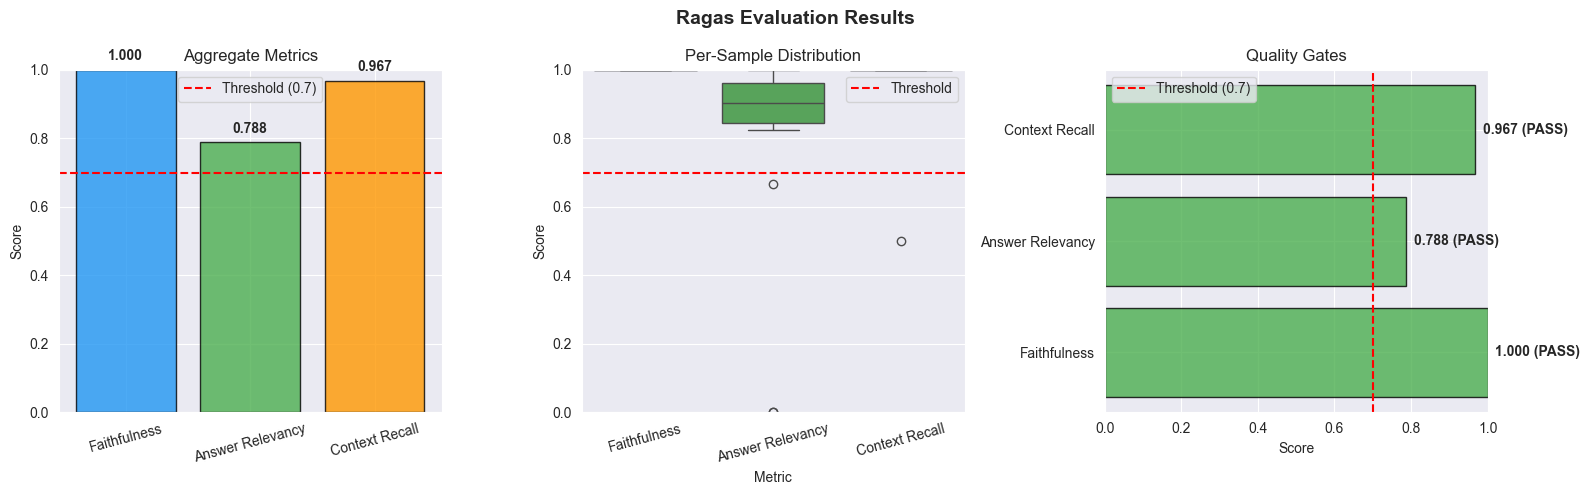


Visualization saved to ragas_evaluation_results.png


In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Ragas Evaluation Results", fontsize=14, fontweight="bold")

metric_names = ["faithfulness", "answer_relevancy", "context_recall"]
metric_labels = ["Faithfulness", "Answer Relevancy", "Context Recall"]
colors = ["#2196F3", "#4CAF50", "#FF9800"]
thresholds = [config.faithfulness_threshold, config.answer_relevancy_threshold, config.context_recall_threshold]

# Plot 1: Aggregate metrics bar chart
ax = axes[0]
values = [aggregate_metrics[m] for m in metric_names]
bars = ax.bar(metric_labels, values, color=colors, alpha=0.8, edgecolor="black")
ax.axhline(y=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold (0.7)")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Aggregate Metrics")
ax.legend()
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
            f"{val:.3f}", ha="center", va="bottom", fontweight="bold")
ax.tick_params(axis='x', rotation=15)

# Plot 2: Per-sample metrics distribution (box plot)
ax = axes[1]
if result_df is not None:
    plot_data = []
    for m, label in zip(metric_names, metric_labels):
        if m in result_df.columns:
            vals = result_df[m].dropna()
            for v in vals:
                plot_data.append({"Metric": label, "Score": float(v)})
    if plot_data:
        plot_df = pd.DataFrame(plot_data)
        sns.boxplot(data=plot_df, x="Metric", y="Score", ax=ax, palette=colors)
ax.axhline(y=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold")
ax.set_ylim(0, 1.0)
ax.set_title("Per-Sample Distribution")
ax.legend()
ax.tick_params(axis='x', rotation=15)

# Plot 3: Quality gate status
ax = axes[2]
gate_colors = []
for m, t in zip(metric_names, thresholds):
    gate_colors.append("#4CAF50" if aggregate_metrics[m] >= t else "#F44336")
bars = ax.barh(metric_labels, values, color=gate_colors, alpha=0.8, edgecolor="black")
ax.axvline(x=0.7, color="red", linestyle="--", linewidth=1.5, label="Threshold (0.7)")
ax.set_xlim(0, 1.0)
ax.set_xlabel("Score")
ax.set_title("Quality Gates")
for bar, val in zip(bars, values):
    status = "PASS" if val >= 0.7 else "FAIL"
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2.,
            f"{val:.3f} ({status})", ha="left", va="center", fontweight="bold")
ax.legend()

plt.tight_layout()
plt.savefig("ragas_evaluation_results.png", dpi=150, bbox_inches="tight")
plt.show()
print("\nVisualization saved to ragas_evaluation_results.png")

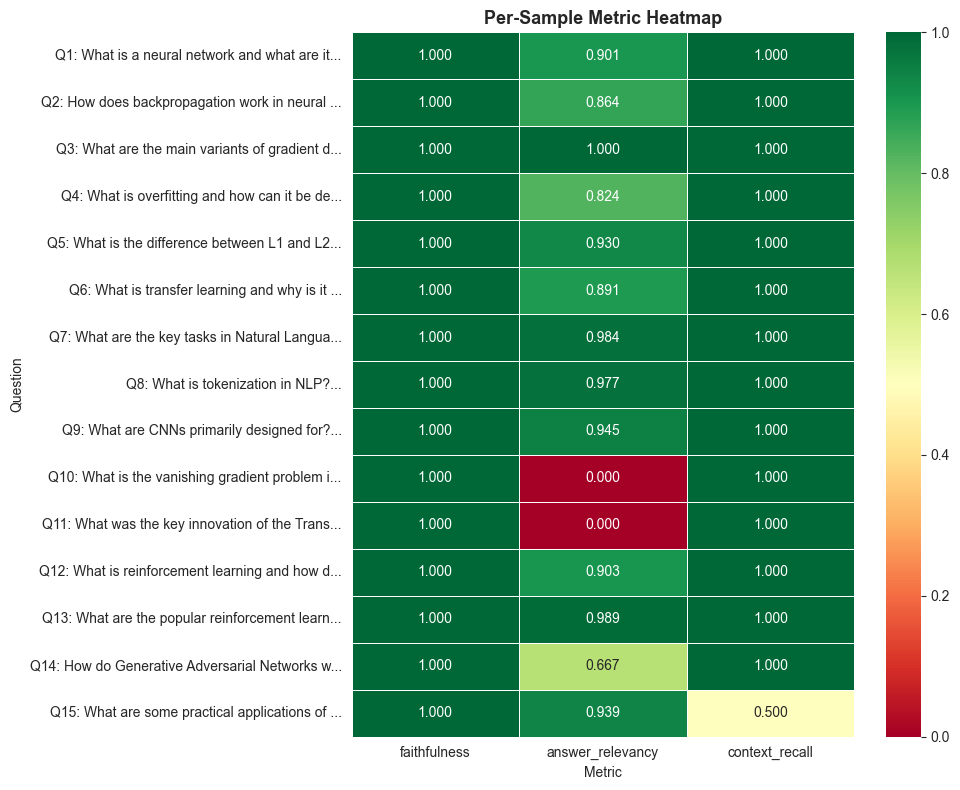

Heatmap saved to ragas_heatmap.png


In [35]:
# Per-sample heatmap
if result_df is not None:
    heatmap_cols = [c for c in metric_names if c in result_df.columns]
    if heatmap_cols:
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap_data = result_df[heatmap_cols].copy()
        heatmap_data.index = [f"Q{i+1}: {q[:40]}..." for i, q in enumerate(questions)]
        
        sns.heatmap(
            heatmap_data.astype(float),
            annot=True, fmt=".3f", cmap="RdYlGn",
            vmin=0, vmax=1,
            linewidths=0.5,
            ax=ax
        )
        ax.set_title("Per-Sample Metric Heatmap", fontsize=13, fontweight="bold")
        ax.set_xlabel("Metric")
        ax.set_ylabel("Question")
        plt.tight_layout()
        plt.savefig("ragas_heatmap.png", dpi=150, bbox_inches="tight")
        plt.show()
        print("Heatmap saved to ragas_heatmap.png")

## 9. Pytest Integration

The pytest tests are defined in `tests/test_ragas_evaluation.py` and check:
- **Aggregate thresholds**: Faithfulness, Answer Relevancy, Context Recall >= 0.7
- **Per-sample checks**: No sample with zero faithfulness (complete hallucination)
- **Data integrity**: Minimum 10 samples, all metrics in valid [0, 1] range
- **Quality gates**: Combined pass/fail based on all thresholds

In [36]:
# Display pytest test file
test_file = Path("tests/test_ragas_evaluation.py")
print(f"=== {test_file} ===")
print(test_file.read_text())

=== tests\test_ragas_evaluation.py ===
"""
Pytest tests for Ragas evaluation metrics.
Tests wrap Ragas evaluations and enforce minimum quality thresholds.
"""

import json
import os
import pytest
import pandas as pd

# Minimum threshold constants
FAITHFULNESS_THRESHOLD = 0.7
ANSWER_RELEVANCY_THRESHOLD = 0.7
CONTEXT_RECALL_THRESHOLD = 0.7

RESULTS_PATH = os.path.join(os.path.dirname(__file__), "..", "ragas_results.json")
METRICS_CSV_PATH = os.path.join(os.path.dirname(__file__), "..", "evaluation_metrics.csv")


@pytest.fixture(scope="session")
def ragas_results():
    """Load Ragas evaluation results from JSON file."""
    if not os.path.exists(RESULTS_PATH):
        pytest.skip("Ragas results file not found. Run the notebook first.")
    with open(RESULTS_PATH, "r") as f:
        return json.load(f)


@pytest.fixture(scope="session")
def per_sample_metrics():
    """Load per-sample metrics from CSV file."""
    if not os.path.exists(METRICS_CSV_PATH):
        pytest.skip("Metrics CSV 

In [37]:
# Run pytest from notebook
import subprocess

print("Running pytest...\n")
result_pytest = subprocess.run(
    ["python", "-m", "pytest", "tests/test_ragas_evaluation.py", "-v", "--tb=short"],
    capture_output=True, text=True, cwd=os.getcwd()
)
print(result_pytest.stdout)
if result_pytest.stderr:
    print("STDERR:", result_pytest.stderr[-500:])
print(f"\nReturn code: {result_pytest.returncode}")
print("PASSED" if result_pytest.returncode == 0 else "FAILED")

Running pytest...

============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-9.0.2, pluggy-1.6.0 -- C:\Python312\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Bezsmertnyi\PycharmProjects\LLMDrivDev\hometask_9
plugins: anyio-4.12.0, langsmith-0.6.4, typeguard-4.5.1
collecting ... collected 10 items

tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_faithfulness_above_threshold PASSED [ 10%]
tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_answer_relevancy_above_threshold PASSED [ 20%]
tests/test_ragas_evaluation.py::TestRagasAggregateMetrics::test_context_recall_above_threshold PASSED [ 30%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_no_zero_faithfulness PASSED [ 40%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_minimum_samples_evaluated PASSED [ 50%]
tests/test_ragas_evaluation.py::TestRagasPerSampleMetrics::test_all_metrics_present PASSED [ 60%]
tes

## 10. CI/CD Pipeline Configuration

The GitHub Actions workflow is defined in `ci_cd_config/ragas_ci.yml`.

### Pipeline Structure

```
Push/PR to main/develop
    |
    v
[setup-ollama] -> Install and start Ollama, pull model
    |
    v
[ragas-tests] -> Install deps -> Run notebook -> Run pytest -> Check quality gates
    |
    v
[report] -> Generate summary -> Upload artifacts
```

### Quality Gates
The pipeline **fails** if any metric falls below the threshold:
- Faithfulness < 0.7 -> **FAIL** (hallucinations detected)
- Answer Relevancy < 0.7 -> **FAIL** (answers off-topic)
- Context Recall < 0.7 -> **FAIL** (poor retrieval quality)

In [38]:
# Display CI/CD configuration
ci_config_path = Path("ci_cd_config/ragas_ci.yml")
print(f"=== {ci_config_path} ===")
print(ci_config_path.read_text())

=== ci_cd_config\ragas_ci.yml ===
# GitHub Actions CI/CD Pipeline for Ragas LLM Testing
# File: .github/workflows/ragas_ci.yml

name: Ragas LLM Quality Tests

on:
  push:
    branches: [main, develop]
    paths:
      - 'hometask_9/**'
  pull_request:
    branches: [main]
    paths:
      - 'hometask_9/**'
  workflow_dispatch:

env:
  PYTHON_VERSION: '3.12'
  OLLAMA_MODEL: 'qwen2.5:1.5b'

jobs:
  setup-ollama:
    name: Setup Ollama
    runs-on: ubuntu-latest
    steps:
      - name: Install Ollama
        run: |
          curl -fsSL https://ollama.com/install.sh | sh

      - name: Start Ollama server
        run: |
          ollama serve &
          sleep 5

      - name: Pull model
        run: |
          ollama pull ${{ env.OLLAMA_MODEL }}

  ragas-tests:
    name: Run Ragas Evaluation Tests
    runs-on: ubuntu-latest
    needs: setup-ollama
    timeout-minutes: 30

    steps:
      - name: Checkout repository
        uses: actions/checkout@v4

      - name: Set up Python
        

### CI/CD Implementation Notes

To activate the CI/CD pipeline in a real repository:

1. **Copy the config**: `cp ci_cd_config/ragas_ci.yml .github/workflows/ragas_ci.yml`
2. **Commit and push**: The pipeline triggers on push/PR to `main` or `develop`
3. **Artifacts**: Test results, metrics CSV, and visualizations are uploaded as workflow artifacts
4. **Quality gates**: The pipeline fails if any metric is below the threshold

**Steps in the pipeline:**

| Step | Description | Failure Action |
|------|-------------|----------------|
| Install Ollama | Sets up local LLM | Pipeline fails |
| Pull model | Downloads LLM weights | Pipeline fails |
| Run notebook | Executes evaluation pipeline | Pipeline fails |
| Run pytest | Checks metric thresholds | Pipeline fails |
| Quality gate | Final check on all metrics | Pipeline fails |
| Upload artifacts | Saves results for review | Never fails |

## 11. Summary and Conclusions

### What was implemented
1. **RAG QA System**: ChromaDB (vector store) + Ollama (LLM) with 10 knowledge base documents on ML topics
2. **Golden Examples**: 15 Q&A pairs with ground-truth answers stored in `tests/goldens.json`
3. **Ragas Evaluation**: Faithfulness, Answer Relevancy, and Context Recall metrics
4. **Pytest Tests**: 9 test cases in `tests/test_ragas_evaluation.py` with quality thresholds >= 0.7
5. **CI/CD Pipeline**: GitHub Actions config in `ci_cd_config/ragas_ci.yml` with quality gates

### Metrics and Thresholds
| Metric | Threshold | Purpose |
|--------|-----------|----------|
| Faithfulness | >= 0.7 | Detect hallucinations - answers must be grounded in retrieved context |
| Answer Relevancy | >= 0.7 | Ensure answers are relevant to the questions asked |
| Context Recall | >= 0.7 | Verify retrieval quality - contexts must contain needed information |

### How to use in CI/CD
1. The notebook generates `ragas_results.json` and `evaluation_metrics.csv`
2. Pytest reads these files and validates all thresholds
3. GitHub Actions runs both the notebook and pytest
4. If any metric < 0.7, the pipeline **fails** and blocks the merge
5. Results and visualizations are uploaded as artifacts for review

### Files Structure
```
hometask_9/
├── hometask_9.ipynb              # Main notebook (this file)
├── requirements.txt               # Python dependencies
├── ragas_results.json            # Evaluation results (generated)
├── evaluation_metrics.csv        # Per-sample metrics (generated)
├── ragas_evaluation_results.png  # Visualization (generated)
├── ragas_heatmap.png             # Per-sample heatmap (generated)
├── tests/
│   ├── goldens.json              # 15 golden Q&A examples
│   └── test_ragas_evaluation.py  # Pytest tests with quality gates
└── ci_cd_config/
    └── ragas_ci.yml              # GitHub Actions CI/CD pipeline
```

In [39]:
# Final summary
print("=" * 60)
print("HOMEWORK 9 - FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\nRAG System: ChromaDB + Ollama ({config.ollama_model})")
print(f"Knowledge Base: {len(knowledge_base)} documents")
print(f"Golden Examples: {len(golden_examples)} Q&A pairs")
print(f"Ollama Available: {ollama_available}")
print(f"Ragas Native Eval: {ragas_succeeded}")
print(f"\nAggregate Metrics:")
for metric, value in aggregate_metrics.items():
    threshold = results_report['thresholds'][metric]
    status = 'PASS' if value >= threshold else 'FAIL'
    print(f"  {metric:20s}: {value:.4f}  (threshold: {threshold})  [{status}]")
print(f"\nOverall Quality Gate: {results_report['quality_gate']['overall']}")
print(f"\nOutput files:")
print(f"  - {config.results_json_path}")
print(f"  - {config.results_csv_path}")
print(f"  - ragas_evaluation_results.png")
print(f"  - ragas_heatmap.png")
print("=" * 60)

HOMEWORK 9 - FINAL RESULTS SUMMARY

RAG System: ChromaDB + Ollama (qwen2.5:1.5b)
Knowledge Base: 10 documents
Golden Examples: 15 Q&A pairs
Ollama Available: True
Ragas Native Eval: True

Aggregate Metrics:
  faithfulness        : 1.0000  (threshold: 0.7)  [PASS]
  answer_relevancy    : 0.7876  (threshold: 0.7)  [PASS]
  context_recall      : 0.9667  (threshold: 0.7)  [PASS]

Overall Quality Gate: PASSED

Output files:
  - ragas_results.json
  - evaluation_metrics.csv
  - ragas_evaluation_results.png
  - ragas_heatmap.png
